# An Analysis of COVID-19 Mortality Rates in U.S. Counties

In [97]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

## Question Framing

My project is based around tracking and predicting counties' Covid related death rates with regards to the national average. I specifically wanted to know if there were indicators in the data that could be used to predict whether a county would fall above or below the national average. I also wanted to see if I could go so far as to predict the exact death rates, however, I was not very successful in this endeavor. 

My motivation behind examining these two questions was based around the intensive news coverage surrounding the varying degrees to which different parts of the country had been hit by the pandemic, as well as their differing reactions. I was curious if one could predict the severity of the crisis within different parts of the US (measured by death rate), as well as potentially link that severity with certain characteristics held by the area. 

The average death rate (# dead / confirmed cases) in the United States is approximately 4.3%. I chose to use the national rate as a rough baseline as there was no county that could be used as a base comparison for others. The national rate, while undoubtedly much more complex (in both the number of variables and the interactions of those variables) at least provides a blanket standard against which to measure the individual counties' death rates.

## Data Cleaning

I began by loading in the data that I was planning on using. In order to compare death rates with county features, I needed to first merge the Confirmed Cases and the Deaths data frames based on county. I then calculated the death rate by dividing the total number of deaths until 4/18/20 (the end of the data collection) by the total number of confirmed cases by the same date. After cleaning the data a bit, which included dropping unnecessary columns, renaming confusing columns, as well as removing NaN and INF values, I merged the already combined DF into the Counties DF, allowing me to compare death rates with potential indicators. For removing the NaN and INF values, while I was somewhat concerned about decreasing the accuracy of my model (due to having fewer data points), I believed the risk of potential bias created by filling the values in (due to the fact that in this case lack of data does not necessarily mean no COVID deaths or cases) outweighed that concern. I also restricted my analysis to counties with at least 1 death, as there were a large number of counties with 1 or no cases who's data would have a negligible or even negative effect on the model (such few cases do not represent a county's vulnerability, but rather appear as anomalies in the county health). 

I did run into some problems merging the DF's however, as there are a large number of counties in different states that share names, yet the only common column along which to merge the Counties DF with the others is county names. I believed I had solved this problem by joining the county names with the states they were in, then using that combination as an updated key, however, I then found out that many counties, most notably New York City, and specifically all of those in Puerto Rico and Alaska, as well as a large number in Virginia, were listed without states. Though I attempted to add the state names manually, the number proved unmanageable and so I was forced to cut these counties from the analysis. I see this as a major flaw in my project, as NYC specifically is the epicenter of the epidemic in the US, making its information particularly valuable.

In [98]:
counties_original = pd.read_csv('abridged_couties.csv')
cases_original = pd.read_csv('time_series_covid19_confirmed_US.csv')
deaths_original = pd.read_csv('time_series_covid19_deaths_US.csv')
cases_original

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,128,130,133,133,133,133,135,135,136,136
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,11,11,11,11,11,11,13,13,13,14
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,683,725,788,897,903,923,974,1043,1068,1118
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,45,50,51,51,51,51,51,51,51,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250,84090055,US,USA,840,90055.0,Unassigned,Wisconsin,US,0.0000,0.0000,...,0,0,0,0,0,1,1,0,0,0
3251,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
3252,84099999,US,USA,840,99999.0,NaN,Grand Princess,US,0.0000,0.0000,...,103,103,103,103,103,103,103,103,103,103
3253,84070004,US,USA,840,NaN,Michigan Department of Corrections (MDOC),Michigan,US,0.0000,0.0000,...,0,0,0,0,370,429,472,472,514,550


In [99]:
cases = cases_original[['UID', 'Admin2', '4/18/20']]
cases = cases.rename(columns={"4/18/20": "Cases as of 4/18/20", 'Admin2' : 'County'})
deaths = deaths_original[['UID', 'Combined_Key', '4/18/20']]
deaths = deaths.rename(columns = {'4/18/20': 'Deaths as of 4/18/20'})
death_rate_df = cases.set_index('UID').join(deaths.set_index('UID'))
death_rate_df.reset_index().drop(['UID'], axis=1)
death_rate_df['Death Rate'] = death_rate_df['Deaths as of 4/18/20'] / death_rate_df['Cases as of 4/18/20']
death_rate_df = death_rate_df.replace([np.inf, -np.inf], np.nan)
death_rate_df = death_rate_df.dropna()
death_rate_df.sort_values(by=['Cases as of 4/18/20'], ascending=False)
#death_rate_df.to_csv('Death Rate DF.csv', index = False)

,County,Cases as of 4/18/20,Combined_Key,Deaths as of 4/18/20,Death Rate
UID,,,,,
84036061,New York,135572,"New York City, New York, US",13202,0.097380
84036059,Nassau,29180,"Nassau, New York, US",1109,0.038005
84036103,Suffolk,26143,"Suffolk, New York, US",693,0.026508
84036119,Westchester,23179,"Westchester, New York, US",668,0.028819
84017031,Cook,20395,"Cook, Illinois, US",860,0.042167
...,...,...,...,...,...
84027125,Red Lake,1,"Red Lake, Minnesota, US",0,0.000000
84027127,Redwood,1,"Redwood, Minnesota, US",0,0.000000
84050009,Essex,1,"Essex, Vermont, US",0,0.000000


In [100]:
counties_original["Combined_Key"] = counties_original["CountyName"] + ', ' + counties_original["State"] + ', ' + 'US'
counties_original[counties_original['StateName'] == 'NY']
counties_original.isna().sum().head(10)

countyFIPS         0
STATEFP           23
COUNTYFP          23
CountyName         0
StateName          0
State            169
lat              169
lon              169
POP_LATITUDE      23
POP_LONGITUDE     23
dtype: int64

In [101]:
#combined_df = counties_original.join(death_rate_df.set_index('Combined_Key'), on='County, State')
combined_df = pd.merge(counties_original, death_rate_df, on='Combined_Key')
combined_df = combined_df[combined_df['Deaths as of 4/18/20'] >= 1]
combined_df = combined_df[['Combined_Key', 'Cases as of 4/18/20', 'Deaths as of 4/18/20', 'Death Rate', 'PopulationDensityperSqMile2010', 'MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage', '''TotalM.D.'s,TotNon-FedandFed2017''', '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'SVIPercentile']]
combined_df#.sort_values(by=['Deaths as of 4/18/20'], ascending=False)

,Combined_Key,Cases as of 4/18/20,Deaths as of 4/18/20,Death Rate,PopulationDensityperSqMile2010,MedianAge2010,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,"TotalM.D.'s,TotNon-FedandFed2017",#Hospitals,#ICU_beds,dem_to_rep_ratio,SVIPercentile
0,"Autauga, Alabama, US",25,2,0.080000,91.8,37.0,9.9,204.5,56.1,18.081557,50.0,1.0,6.0,0.326656,0.4354
1,"Baldwin, Alabama, US",109,2,0.018349,114.7,41.1,8.5,183.2,41.9,17.489033,536.0,3.0,51.0,0.253255,0.2162
7,"Calhoun, Alabama, US",66,2,0.030303,195.7,38.2,15.6,315.8,44.0,20.612560,228.0,2.0,24.0,0.402921,0.8252
8,"Chambers, Alabama, US",240,11,0.045833,57.4,41.5,17.5,196.7,45.2,19.392927,28.0,0.0,0.0,0.737473,0.7382
16,"Colbert, Alabama, US",15,1,0.066667,91.8,41.8,13.5,261.3,55.2,18.658821,91.0,2.0,22.0,0.436642,0.4274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,"Waupaca, Wisconsin, US",4,1,0.250000,70.1,43.5,9.1,172.8,34.8,15.294101,61.0,2.0,4.0,0.521342,0.1815
2570,"Winnebago, Wisconsin, US",38,1,0.026316,384.4,37.9,8.1,129.0,29.2,15.258878,509.0,2.0,26.0,0.852836,0.1608
2581,"Johnson, Wyoming, US",11,1,0.090909,2.1,44.8,5.5,165.9,33.0,15.028527,19.0,1.0,0.0,0.183492,0.1774
2593,"Broomfield, Colorado, US",98,2,0.020408,1691.9,36.4,6.5,113.8,34.5,11.625378,181.0,1.0,20.0,1.373356,0.0490


## EDA and Data Visualizations

For my EDA, I attempted to isolate the columns in the DF that would best serve as predictors for my model. I first gave each county a score of either 1 (over the national average) or 0 (under the national average), then analyzed both this measure and the county's death rate against the potential predictors in the DF. After plotting the relationship each category had with the county's death rate, as well as sorting the table in multiple ways (comparing the relative maximums and minimums for each category) I decided on Population Density (population density per square mile in the county in 2010), Percentage of Smokers (estimated percentage of adult smokers in the county (2017)), SVIPercentile (the county's overall percentile ranking indicating the CDC's Social Vulnerability Index (SVI); higher ranking indicates greater social vulnerability) and Median Age (median age of county in 2010) as the 4 predictors I would use for my model. 

I originally was interested in analyzing the relationship party affiliation had with death rate, however, while definitely an interesting potential avenue of future research (especially given more recent data), it served only to decrease the accuracy of my model. 

I used multiple visualizations in determining my preferred predictors, however, I have elected to only show those belonging to the predictors I ended up choosing, as I do not have the room for over 30 different visualizations. I primarily used Barplots, Lineplots, and Distribution plots in order to make my comparisons.

In [102]:
result = [x >= .043 for x in combined_df['Death Rate']]
combined_df['Death Rate over National Avg?'] = result

In [103]:
combined_df = combined_df*1
combined_df

,Combined_Key,Cases as of 4/18/20,Deaths as of 4/18/20,Death Rate,PopulationDensityperSqMile2010,MedianAge2010,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,"TotalM.D.'s,TotNon-FedandFed2017",#Hospitals,#ICU_beds,dem_to_rep_ratio,SVIPercentile,Death Rate over National Avg?
0,"Autauga, Alabama, US",25,2,0.080000,91.8,37.0,9.9,204.5,56.1,18.081557,50.0,1.0,6.0,0.326656,0.4354,1
1,"Baldwin, Alabama, US",109,2,0.018349,114.7,41.1,8.5,183.2,41.9,17.489033,536.0,3.0,51.0,0.253255,0.2162,0
7,"Calhoun, Alabama, US",66,2,0.030303,195.7,38.2,15.6,315.8,44.0,20.612560,228.0,2.0,24.0,0.402921,0.8252,0
8,"Chambers, Alabama, US",240,11,0.045833,57.4,41.5,17.5,196.7,45.2,19.392927,28.0,0.0,0.0,0.737473,0.7382,1
16,"Colbert, Alabama, US",15,1,0.066667,91.8,41.8,13.5,261.3,55.2,18.658821,91.0,2.0,22.0,0.436642,0.4274,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,"Waupaca, Wisconsin, US",4,1,0.250000,70.1,43.5,9.1,172.8,34.8,15.294101,61.0,2.0,4.0,0.521342,0.1815,1
2570,"Winnebago, Wisconsin, US",38,1,0.026316,384.4,37.9,8.1,129.0,29.2,15.258878,509.0,2.0,26.0,0.852836,0.1608,0
2581,"Johnson, Wyoming, US",11,1,0.090909,2.1,44.8,5.5,165.9,33.0,15.028527,19.0,1.0,0.0,0.183492,0.1774,1
2593,"Broomfield, Colorado, US",98,2,0.020408,1691.9,36.4,6.5,113.8,34.5,11.625378,181.0,1.0,20.0,1.373356,0.0490,0


Text(0.5, 1.0, '25 Counties with the Highest Death Rates')

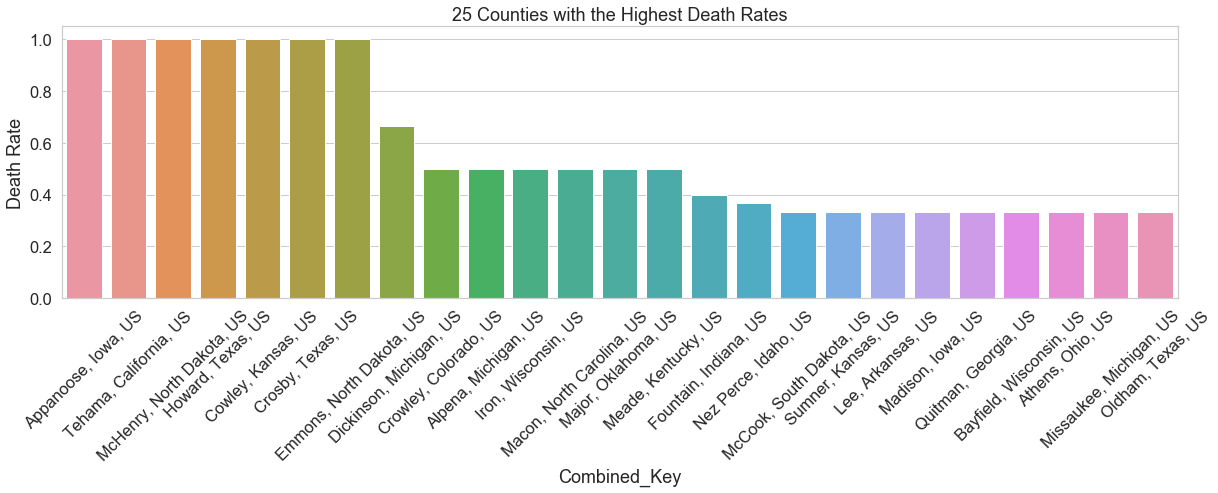

In [104]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x="Combined_Key", y="Death Rate", data=combined_df.sort_values(by=['Death Rate'], ascending=False).head(25))
plt.xticks(rotation=45)
plt.title('25 Counties with the Highest Death Rates')

The following are a series of visualizations I used in order to determine the best features of my model. They allowed me to determine correllations between death rate and the various features, as well as allowed me to compare the features between counties over the national average and counties under it. 

Text(0.5, 1.0, 'Death Rate vs Pop Density')

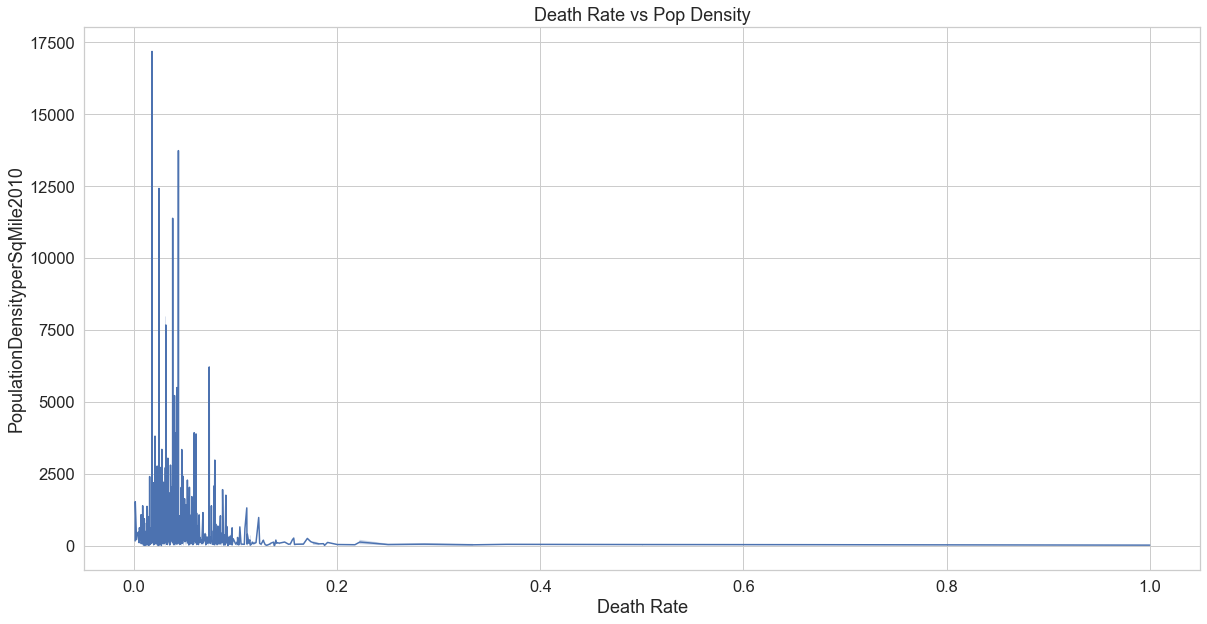

In [105]:
over = combined_df[combined_df['Death Rate over National Avg?'] == 1]
under = combined_df[combined_df['Death Rate over National Avg?'] == 0]
plt.figure(figsize=(20,10))
ax = sns.lineplot(x="Death Rate", y="PopulationDensityperSqMile2010", data=combined_df)
plt.title('Death Rate vs Pop Density')

Text(0.5, 1.0, 'Death Rate vs Pop Density')

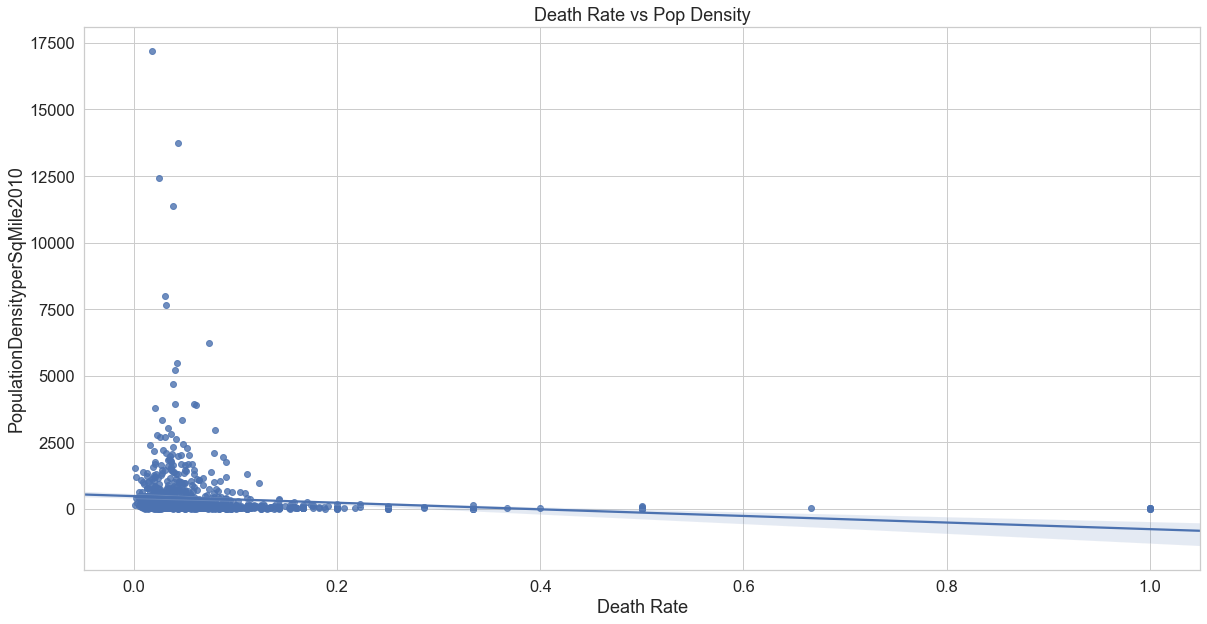

In [106]:
plt.figure(figsize=(20,10))
ax = sns.regplot(x="Death Rate", y="PopulationDensityperSqMile2010", data=combined_df)
plt.title('Death Rate vs Pop Density')

Text(0.5, 1.0, 'Death Rate vs Smokers %')

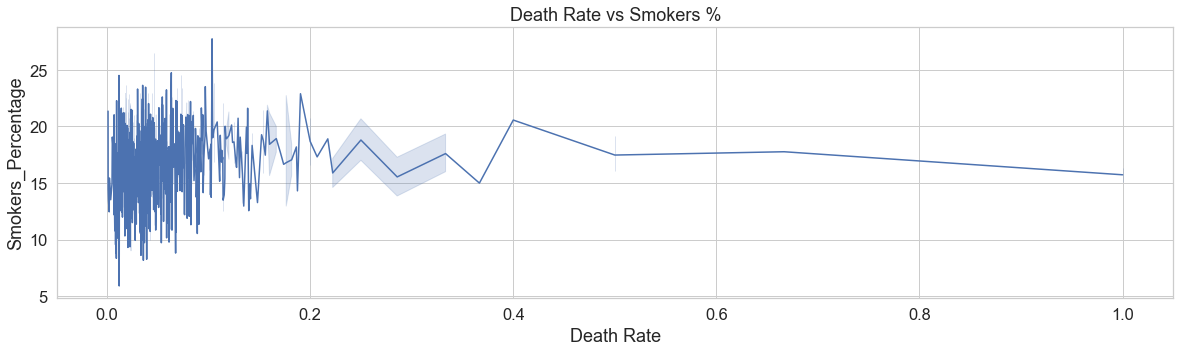

In [107]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(x="Death Rate", y="Smokers_Percentage", data=combined_df)
plt.title('Death Rate vs Smokers %')

Text(0.5, 1.0, 'Death Rate vs Smokers %')

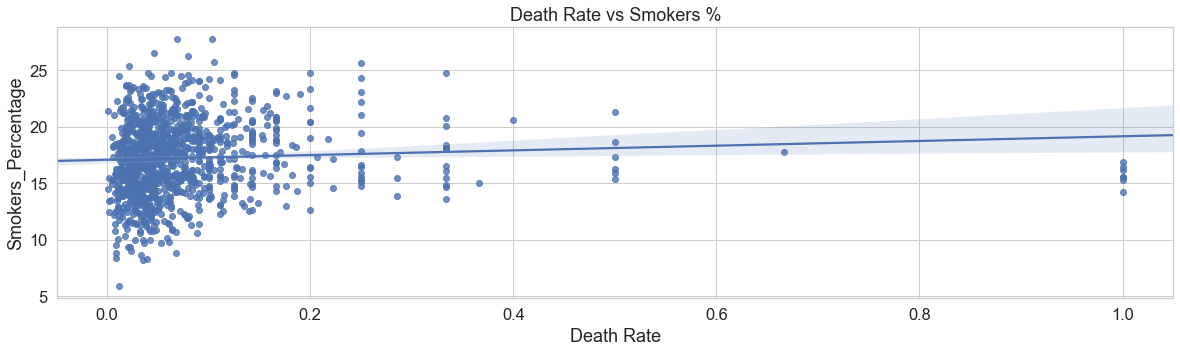

In [108]:
plt.figure(figsize=(20,5))
ax = sns.regplot(x="Death Rate", y="Smokers_Percentage", data=combined_df)
plt.title('Death Rate vs Smokers %')

Text(0.5, 1.0, 'Death Rate vs Median Age')

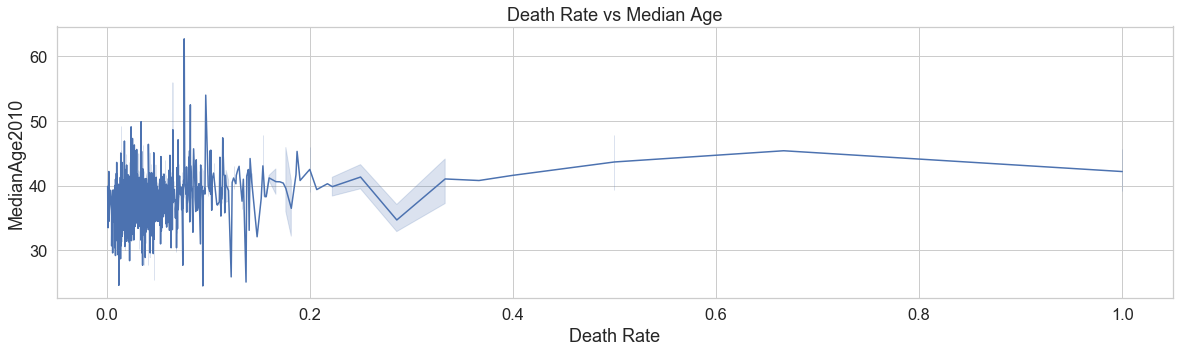

In [109]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(x="Death Rate", y="MedianAge2010", data=combined_df)
plt.title('Death Rate vs Median Age')

Text(0.5, 1.0, 'Death Rate vs Median Age')

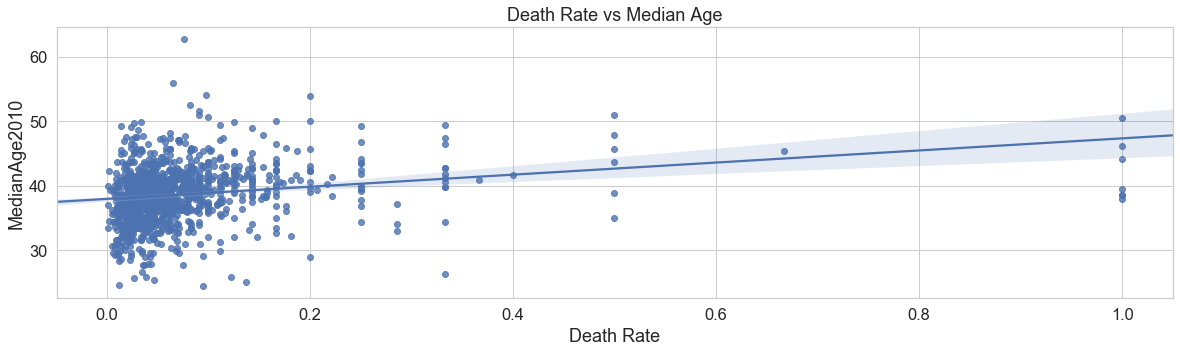

In [110]:
plt.figure(figsize=(20,5))
ax = sns.regplot(x="Death Rate", y="MedianAge2010", data=combined_df)
plt.title('Death Rate vs Median Age')

Text(0.5, 1.0, 'Death Rate vs SVI Percentile')

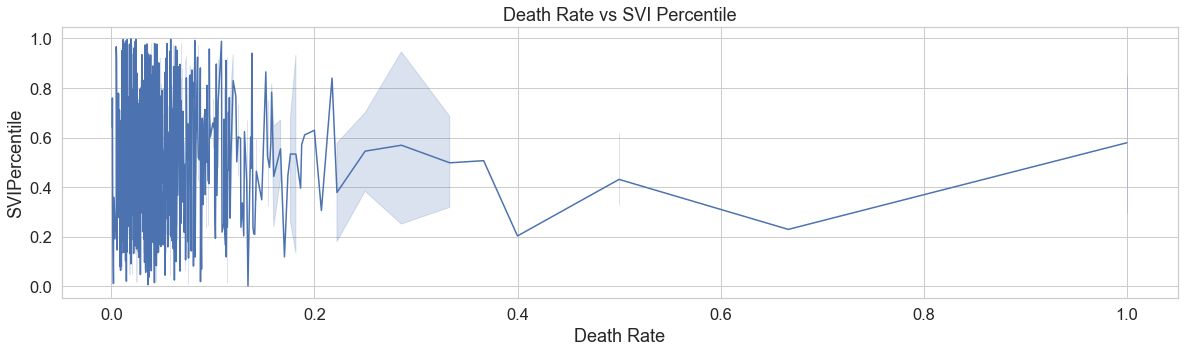

In [111]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(x="Death Rate", y="SVIPercentile", data=combined_df)
plt.title('Death Rate vs SVI Percentile')

Text(0.5, 1.0, 'Death Rate vs SVI Percentile')

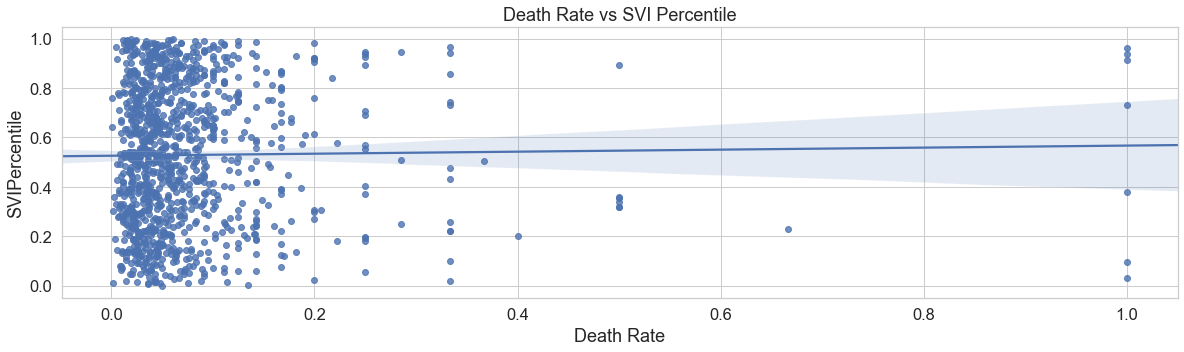

In [112]:
plt.figure(figsize=(20,5))
ax = sns.regplot(x="Death Rate", y="SVIPercentile", data=combined_df)
plt.title('Death Rate vs SVI Percentile')

Text(0.5, 1.0, 'Death Rate vs Dem to Rep Ratio')

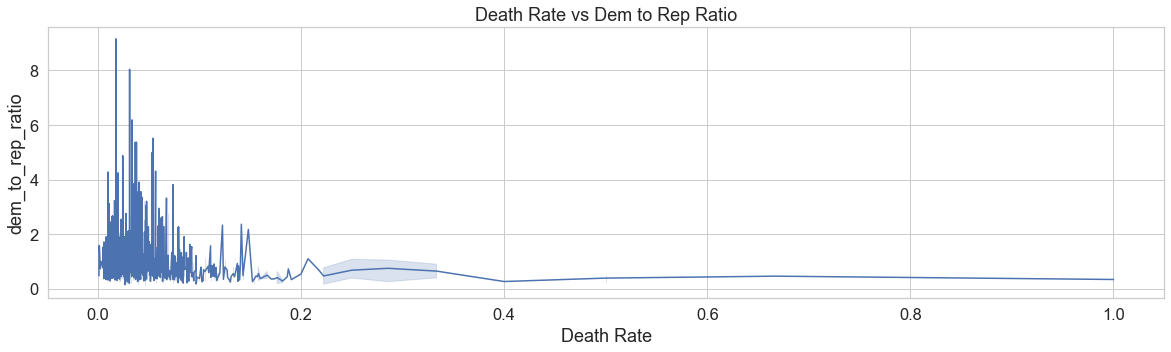

In [113]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(x="Death Rate", y="dem_to_rep_ratio", data=combined_df)
plt.title('Death Rate vs Dem to Rep Ratio')

Text(0.5, 1.0, 'Death Rate vs Dem to Rep Ratio')

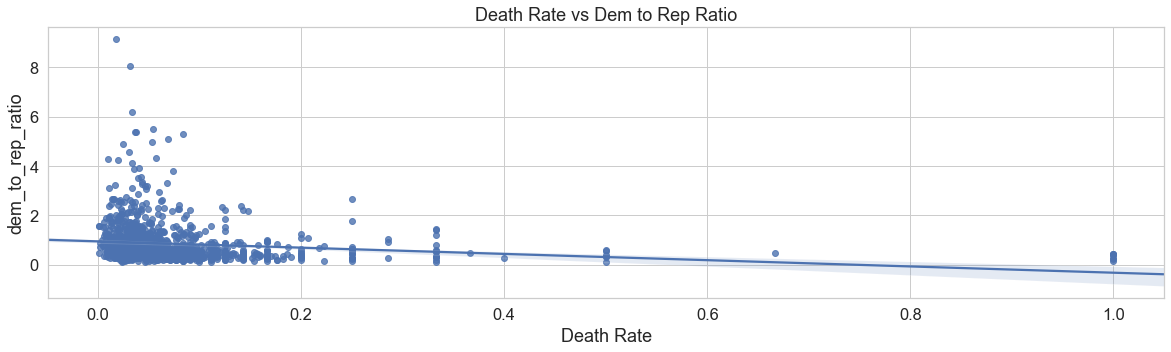

In [114]:
plt.figure(figsize=(20,5))
ax = sns.regplot(x="Death Rate", y="dem_to_rep_ratio", data=combined_df)
plt.title('Death Rate vs Dem to Rep Ratio')

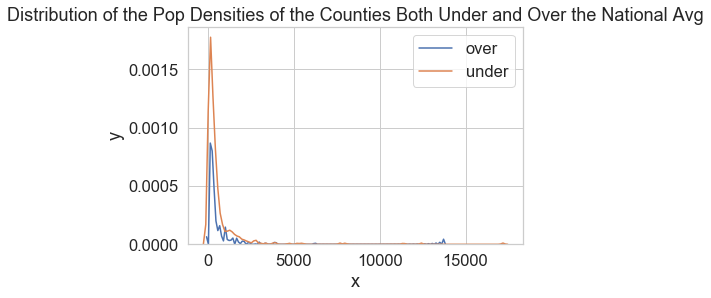

In [115]:
plt.figure()
plt.title('Distribution of the Pop Densities of the Counties Both Under and Over the National Avg')
#plt.xlim(0,20000)
over_plot = sns.distplot(over['PopulationDensityperSqMile2010'], label='over', hist=False)
under_plot = sns.distplot(under['PopulationDensityperSqMile2010'], label='under', hist=False)
over_plot.set(xlabel='x', ylabel='y')
plt.legend()
plt.show()


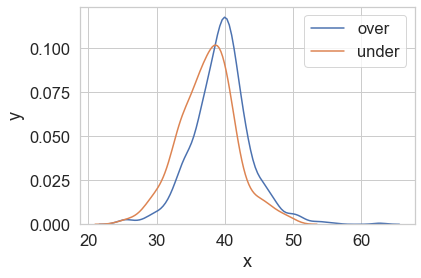

In [116]:
plt.figure()
#plt.xlim(0,20000)
over_plot = sns.distplot(over['MedianAge2010'], label='over', hist=False)
under_plot = sns.distplot(under['MedianAge2010'], label='under', hist=False)
over_plot.set(xlabel='x', ylabel='y')
plt.legend()
plt.show()

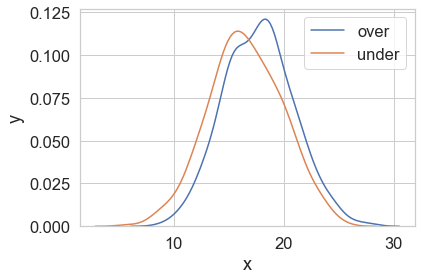

In [117]:
plt.figure()
#plt.xlim(0,20000)
over_plot = sns.distplot(over['Smokers_Percentage'], label='over', hist=False)
under_plot = sns.distplot(under['Smokers_Percentage'], label='under', hist=False)
over_plot.set(xlabel='x', ylabel='y')
plt.legend()
plt.show()

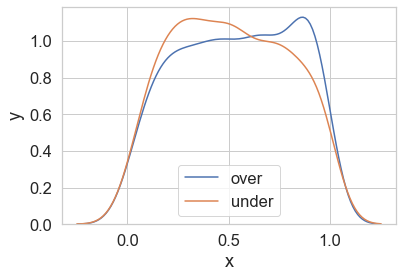

In [118]:
plt.figure()
#plt.xlim(0,20000)
over_plot = sns.distplot(over['SVIPercentile'], label='over', hist=False)
under_plot = sns.distplot(under['SVIPercentile'], label='under', hist=False)
over_plot.set(xlabel='x', ylabel='y')
plt.legend()
plt.show()

## Method and Experiments

For my experiments, I first attempted to predict the total deaths in each county based on the 4 predictors I chose. I used them to fit a training set I had split from 80% of the data using the SKLearn linear regression model (due to the continuous nature of the outcome I was looking for), then tested my model on the remaining 20% of the data (standard train/test split). Though my model was pretty inaccurate, as demonstrated by the bar graph, it still proved to be an interesting analysis. Though the majority of my predicted values were substantially off from the actual values, through multiple iterations of the model, I was able to, I believe, determine that the variables given in the dataset are insufficient to perform this sort of prediction. The actual number of deaths in each county, as well as the counties themselves, vary too greatly to create such an accurate prediction.   

I next attempted to predict, using the same predictors but fitted using logistic regression (due to the binary nature of my target: either 1 for over or 0 for under the national avg), whether a county would fall above or below the national average death rate of 4.3%. In this, I was substantially more successful, and I was able to bring my model from a training accuracy of 12.25% all the way up to 63.43% (I was performing EDA while building my models, thus I was able to bring the accuracy up by going back and forth substituting in different predictors) which I consider a massive improvement. I believe I was more successful because the variables given in the dataset serve as better indicators of severity, rather than actual deaths. They highlight the potential weaknesses or vulnerabilities each county has in relation to one another, which, when given a standard against which to measure (national average), allows us to create a relatively accurate severity prediction. 


### Linear Regression

Here I attempted to predict the total Covid related deaths experienced by a county using the predictors I deemed best in my EDA in a linear regression model.

In [119]:
combined_df#.to_csv('Combined DF.csv', index = False)

,Combined_Key,Cases as of 4/18/20,Deaths as of 4/18/20,Death Rate,PopulationDensityperSqMile2010,MedianAge2010,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,"TotalM.D.'s,TotNon-FedandFed2017",#Hospitals,#ICU_beds,dem_to_rep_ratio,SVIPercentile,Death Rate over National Avg?
0,"Autauga, Alabama, US",25,2,0.080000,91.8,37.0,9.9,204.5,56.1,18.081557,50.0,1.0,6.0,0.326656,0.4354,1
1,"Baldwin, Alabama, US",109,2,0.018349,114.7,41.1,8.5,183.2,41.9,17.489033,536.0,3.0,51.0,0.253255,0.2162,0
7,"Calhoun, Alabama, US",66,2,0.030303,195.7,38.2,15.6,315.8,44.0,20.612560,228.0,2.0,24.0,0.402921,0.8252,0
8,"Chambers, Alabama, US",240,11,0.045833,57.4,41.5,17.5,196.7,45.2,19.392927,28.0,0.0,0.0,0.737473,0.7382,1
16,"Colbert, Alabama, US",15,1,0.066667,91.8,41.8,13.5,261.3,55.2,18.658821,91.0,2.0,22.0,0.436642,0.4274,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,"Waupaca, Wisconsin, US",4,1,0.250000,70.1,43.5,9.1,172.8,34.8,15.294101,61.0,2.0,4.0,0.521342,0.1815,1
2570,"Winnebago, Wisconsin, US",38,1,0.026316,384.4,37.9,8.1,129.0,29.2,15.258878,509.0,2.0,26.0,0.852836,0.1608,0
2581,"Johnson, Wyoming, US",11,1,0.090909,2.1,44.8,5.5,165.9,33.0,15.028527,19.0,1.0,0.0,0.183492,0.1774,1
2593,"Broomfield, Colorado, US",98,2,0.020408,1691.9,36.4,6.5,113.8,34.5,11.625378,181.0,1.0,20.0,1.373356,0.0490,0


In [120]:
x = combined_df[['PopulationDensityperSqMile2010', 'Smokers_Percentage', 'SVIPercentile', 'MedianAge2010']]
y = combined_df['Deaths as of 4/18/20']
len(y)

1136

In [121]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [122]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()  
regressor.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [123]:
y_pred = regressor.predict(x_test)

In [124]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head(25)

,Actual,Predicted
1655,4,19.696133
1905,36,35.897365
558,3,14.239631
1741,1,1.047302
639,4,5.644079
231,10,7.715436
1232,14,6.117482
156,19,100.468635
1595,5,45.821692
444,1,10.623104


As demonstrated below, the massive differences between my predicted values and actual values highlight the inaccuracy of this model.

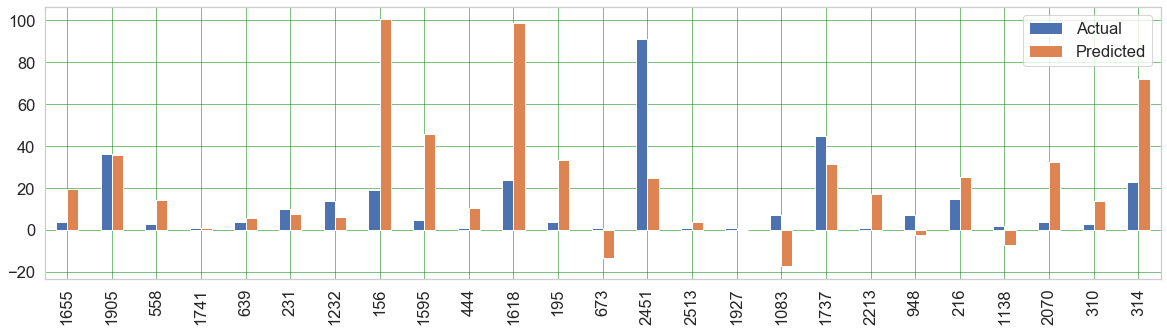

In [125]:
df.head(25).plot(kind='bar',figsize=(20, 5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Logistic Regression

Here I attempted to predict if a county would surpass the national Covid death rate based on the predictors I deemed best in EDA, using a logistic regression model. 

In [126]:
X1 = combined_df[['PopulationDensityperSqMile2010', 'Smokers_Percentage', 'SVIPercentile', 'MedianAge2010']]
Y1 = combined_df['Death Rate over National Avg?']

In [127]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)

In [128]:
from sklearn.linear_model import LogisticRegression

model =  LogisticRegression()
model.fit(X1_train, Y1_train)

training_accuracy = model.score(X1_train, Y1_train)
print("Training Accuracy: ", training_accuracy)
test_accuracy = model.score(X1_test, Y1_test)
print('Test Accuracy: ', test_accuracy)

Training Accuracy:  0.6343612334801763
Test Accuracy:  0.6885964912280702


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [129]:
test_predictions = model.predict(X1_test)
test_predictions

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1])

In [130]:
df1 = pd.DataFrame({'Actual': Y1_test, 'Predicted': test_predictions})
df1.head(25)

,Actual,Predicted
1655,0,1
1905,0,1
558,0,0
1741,1,1
639,1,1
231,1,1
1232,1,1
156,0,0
1595,0,1
444,1,1


As demonstrated below, this model is much more accurate, with the far fewer differences between the predicted and actual values (the values show this by matchinng up, 1 to 1, and 0 to 0). 

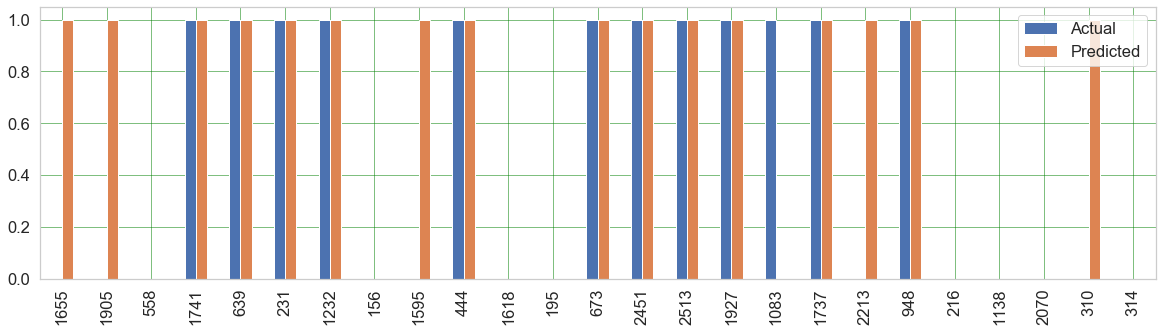

In [131]:
df1.head(25).plot(kind='bar',figsize=(20, 5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Analysis and Conclusions

(i) Two of the most interesting features I came across when attempting to answer my two questions were the importance of both the percentage of smokers and the percentage of the county population that ranked highly on the CDC's Social Vulnerability Index in determining how severely a county would be hit by COVID deaths. The smokers’ percentage would seem to be outweighed in importance by other pre-existing conditions, such as diabetes, heart conditions, etc. or even by the outright mortality rates from respiratory illnesses, yet, when using those variables as features in the models, I achieved far lower standards of accuracy. While I’m not sure why this is the case, I hypothesize that it is possible that smokers take fewer precautions from the virus (from simply sheltering indoors, to using a mask when outside) when compared to those with other pre-existing conditions (though their objective medical vulnerability may be the same), making them experience higher death rates. The SVI percentile’s importance demonstrates how the virus affects the poor and needy much more severely than those of affluence. Poorer counties generally had higher death rates (which coincided with lower numbers of hospitals and ICU beds), making the case for a more class conscious examination of the virus-related death rates. 

(ii) I thought that perhaps a political party based analysis could yield some information as to the differences in the responses of local leadership and citizen bodies with regards to the virus and its death toll, especially in light of the attention the polarized response has gotten in the media. However, further analysis and model testing revealed that there was very little correlation between the two, making the feature unsuitable for model fitting. 

(iii) I had some challenges in data cleaning, as the data was often incomplete, meaning I had to decide where it was appropriate to fill in data (almost never), where my model could, with a mall accuracy penalty, still function despite the missing data, and where I needed to remove or cull the data due to missing values. I worry that missteps in this process affected both the accuracy of and the levels of bias within my model. I also wonder if there are both more recent and more useful data to be found, especially with regards to predicting the actual death tolls or rates (as opposed to just classifying them against the national average).

(iv) The fundamental limitation in my analysis is the lack of accuracy in my model predicting actual death tolls. The variables I had available, while useful in determining relative severity and/or vulnerability, are not as insightful when it comes to the actual quantitative data. I also think that an analysis of the variables given on a national level could  (as opposed to solely county level) could provide some insight into how to more accurately create my logistical regression model. 

(v) The primary ethical problem I had with the data was the lack of HPSA (Health Professional Shortage Area) data, as this would have allowed me to perform a more detailed analysis of the effects of medical resources in the area, and thus class effects on the area. The number of hospitals and ICU beds, while useful, did not provide objective or controlled measures of vulnerability, as the effectiveness of those numbers depend on a host of other variables within the county, whereas HPSA measures are scaled to the county, making them more useable as standards of care. There also appeared to be a lot of useful information in the unabridged counties CSV (which was not included in the dataset, but was visible on the Github page that the set came from), which makes me wonder how the original publisher, and even the course staff, chose this particular information.

(vi) As stated previously, more recent data (this set only goes to the 18th of April), as well as more comprehensive data (on a national scale as well as on a county scale) would help strengthen my analysis. The information on pre-existing conditions, for instance, could include conditions such as asthma and various types of cancer, both of which are extremely common and are affected radically by COVID. The national averages for the information given could also be included, which would provide a better standard of comparison. Finally, a dataset on adherence to anti-viral government measures (social distancing, masks, shelter in place orders, etc.) would help determine population created causes for the differences in severity between counties. 

(vii) The primary ethical concern I had in analyzing these questions was the importance I discovered in the SVI index in determining vulnerability to COVID. Poorer communities, in general, were hit harder than wealthier ones, making the class-based effects of COVID the next obvious avenue of future study. Poverty should not condemn people to higher risk, yet, all too often in the modern world (not just with regards to COVID), it does.


Though I was only partially successful in answering my questions, I believe that this work, especially the classification model, serves as an interesting baseline for future COVID research. While I was originally interested in the political implications of the virus and its death rate, through this work, I saw that perhaps a more relevant and revealing path of analysis would be the economic and class-based implications of the two. I also realized that qualitative data about viruses is much harder to predict than other aspects of society (thinking back to two of the bigger examples in class, tips, or the price of diamonds for instance). I believe this to be due to the unpredictable (and often unknown) means of viral spread, as well as the lack of understanding of how the virus operates. It is difficult to accurately predict death tolls because our knowledge and understanding of the virus is constantly changing. Despite this, however, predictions such as this one create new potential questions for examination and perspectives of thought, making analysis such as this one valuable, if somewhat outdated, or inaccurate.
